# Neural Networks from scratch in Python 

In [3]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data

nnfs.init()

### Dense Layer

In [4]:
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases  = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradient on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases  = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs  = np.dot(dvalues, self.weights.T)

### ReLU activation

In [5]:
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        self.inputs = inputs

        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable, 
        # let's make a copy of the variable first 
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

### Softmax activation

In [6]:
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))

        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1,1)
            # Calculate Jacobian matrix of the output ...
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            # Calculate sample-wise gradient and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

### Common loss class

In [7]:
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        return np.mean(sample_losses)

    def forward(self, y_pred, y_true):
        return []

### Cross-entropy loss (subclass to Loss)

In [8]:
class Loss_CategoricalCrossentropy(Loss):

    # Forwad pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        # Probabilities for target values - 
        # only if categorical labels
        # correct_confidences = 0  # Remove warning!
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        
        #else:
        #    print("ERROR!")
        #    correct_confidences = 0

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample.
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector 
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true / dvalues

        # Normalize gradient
        self.dinputs = self.dinputs / samples

### Activation_Softmax_Loss_CategoricalCrossEntropy

In [9]:
# softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss funtion objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss       = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # If labels are one-hot encoded, turn them into discrete values
        if len(y_true.shape) == 2: 
            y_true = np.argmax(y_true, axis=1)
            
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

### Optimizer SGD (Stochastic Gradient Descent)

In [10]:
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer

    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate          = learning_rate 
        self.current_learning_rate  = learning_rate
        self.decay                  = decay
        self.iterations             = 0
        self.momentum               = momentum
    
    # Call once before any parameters update
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations)) 

    def update_params(self, layer):
        if self.momentum:

            # If layer does not contain momentum arrays, create 
            # them filled with zeroes (weight and biases)
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums   = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous 
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weights_momentums = weight_updates

            # .. and build biases updates 
            bias_updates = \
                self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentum = bias_updates

        else:   
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates   = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases  += bias_updates
        
    # Call once after any parameters updates
    def post_update_params(self):
        self.iterations += 1

### Optimizer AdaGrad - [Adaptive Gradient]

In [11]:
class Optimizer_Adagrad:
    
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1.0, decay=0.0, epsilon=1e-7):
        self.learning_rate          = learning_rate
        self.current_learning_rate  = learning_rate
        self.decay                  = decay
        self.iterations             = 0
        self.epsilon                = epsilon

    # Call once before any parameters updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # Add cache array if layer does not have them
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache   = np.zeros_like(layer.biases )

        # Update cache with squared current gradient
        layer.weight_cache += layer.dweights**2
        layer.bias_cache   += layer.dbiases**2

        # Vanilla SGD Parameter update + normalization with square root cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases  += -self.current_learning_rate * layer.dbiases  / (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

### Optimizer RMSprop - [Root Mean Square Propagation]

In [12]:
class Optimizer_RMSprop:

    # Initialize optimizer
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay*self.iterations))
    
    # Update params
    def update_params(self, layer):

        # Add cache array if layer does not have them
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache   = np.zeros_like(layer.biases )

        # Update cache with squared current gradient
        layer.weight_cache = self.rho * layer.weight_cache + (1-self.rho) * layer.dweights**2
        layer.bias_cache   = self.rho * layer.bias_cache   + (1-self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization with squared cache
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases  += -self.current_learning_rate * layer.dbiases  / (np.sqrt(layer.bias_cache)   + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

### Optimizer Adam - [Adaptive Momentum]

In [13]:
class Optimizer_Adam:

    # Initialize optimizer
    def __init__(self, learning_rate=0.001, decay=0.0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate          = learning_rate
        self.current_learning_rate  = learning_rate
        self.decay                  = decay
        self.iterations             = 0
        self.epsilon                = epsilon
        self.beta_1                 = beta_1
        self.beta_2                 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = \
                self.learning_rate * (1.0 / (1.0+self.decay * self.iterations))
    
    # Update parameters
    def update_params(self, layer):

        # Create cache arrays if not exist
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache     = np.zeros_like(layer.weights)
            layer.bias_momentums   = np.zeros_like(layer.biases)
            layer.bias_cache       = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = \
            self.beta_1 * layer.weight_momentums + (1-self.beta_1)*layer.dweights
        layer.bias_momentums = \
            self.beta_1 * layer.bias_momentums   + (1-self.beta_1)*layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations+1))
        bias_momentums_corrected   = layer.bias_momentums   / (1 - self.beta_1 ** (self.iterations+1))

        # Update cache with squared current gradients
        layer.weight_cache = \
            self.beta_2 * layer.weight_cache + (1-self.beta_2)*layer.dweights**2
        layer.bias_cache = \
            self.beta_2 * layer.bias_cache   + (1-self.beta_2)*layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1-self.beta_2**(self.iterations+1))
        bias_cache_corrected   = layer.bias_cache   / (1-self.beta_2**(self.iterations+1))

        # Vanilla SGD parameter update + normalization with sqrt cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases  += -self.current_learning_rate * bias_momentums_corrected   / (np.sqrt(bias_cache_corrected)   + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

### Run The model

In [14]:
# Create Dataset
X, y = spiral_data(samples=100, classes=3)

# Create the network model. 
dense1      = Layer_Dense(2, 64)
activation1 = Activation_ReLU()
dense2      = Layer_Dense(64,3)

# Create Softmax combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
#optimizer = Optimizer_SGD(learning_rate=1.0, decay=8e-8, momentum=0.9)
optimizer       = Optimizer_Adam(learning_rate=0.02, decay=1e-5)



In [15]:
# Train in loop
for epoch in range(10001):

    # Forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)

    # Loss 
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy. Calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2: 
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100: 
        print(f"epoch: {epoch:05d} | acc: {accuracy:.3f} | loss: {loss:.3f} | lr: {optimizer.current_learning_rate}")

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    

epoch: 00000 | acc: 0.360 | loss: 1.099 | lr: 0.02
epoch: 00100 | acc: 0.673 | loss: 0.769 | lr: 0.01998021958261321
epoch: 00200 | acc: 0.813 | loss: 0.552 | lr: 0.019960279044701046
epoch: 00300 | acc: 0.840 | loss: 0.445 | lr: 0.019940378268975763
epoch: 00400 | acc: 0.863 | loss: 0.380 | lr: 0.01992051713662487
epoch: 00500 | acc: 0.873 | loss: 0.336 | lr: 0.01990069552930875
epoch: 00600 | acc: 0.890 | loss: 0.308 | lr: 0.019880913329158343
epoch: 00700 | acc: 0.890 | loss: 0.287 | lr: 0.019861170418772778
epoch: 00800 | acc: 0.907 | loss: 0.269 | lr: 0.019841466681217078
epoch: 00900 | acc: 0.910 | loss: 0.250 | lr: 0.01982180200001982
epoch: 01000 | acc: 0.913 | loss: 0.238 | lr: 0.019802176259170884
epoch: 01100 | acc: 0.910 | loss: 0.230 | lr: 0.01978258934311912
epoch: 01200 | acc: 0.913 | loss: 0.219 | lr: 0.01976304113677013
epoch: 01300 | acc: 0.920 | loss: 0.210 | lr: 0.019743531525483964
epoch: 01400 | acc: 0.910 | loss: 0.202 | lr: 0.01972406039507293
epoch: 01500 | acc

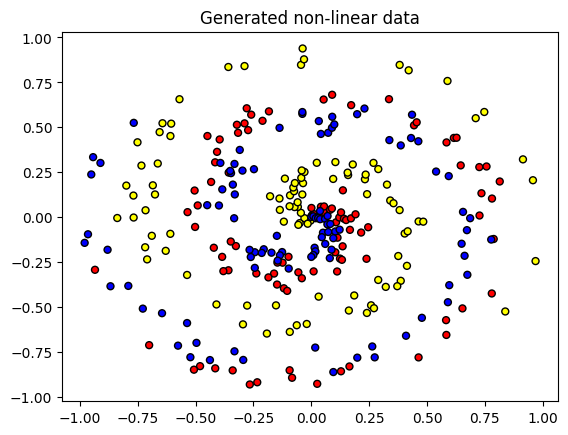

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
from torch import nn
import torch.nn.functional as F

# Visualuze data
plt.title("Generated non-linear data")
colors = {0: 'red', 1: 'yellow', 2: 'blue'}
plt.scatter(X[:,0], X[:,1], c=[colors[_y] for _y in y], edgecolors='k', s=25)
plt.show()

x_min, x_max:  -1.0793868064880372 1.069426989555359
y_min, y_max:  -1.0326150417327882 1.0386551380157472
(101,) (101,) (101,)


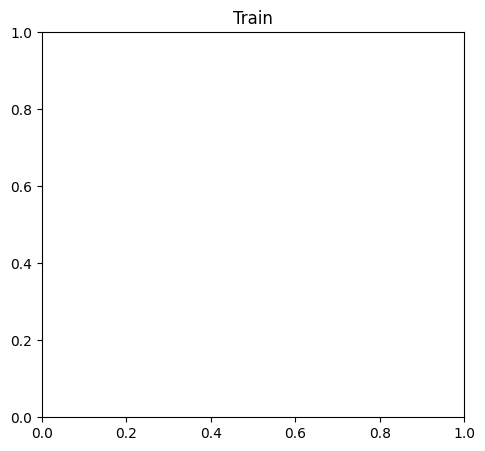

In [67]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")

x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1
print("x_min, x_max: ", x_min, x_max)
print("y_min, y_max: ", y_min, y_max)
t = np.linspace(x_min, x_max, 101)
# print("t: ", t)
xx,yy = np.linspace(y_min, y_max, 101), np.linspace(y_min, y_max, 101)
cmap = plt.cm.Spectral

X_test = np.c_[xx.ravel(), yy.ravel()]
dense1.forward(X_test)
activation1.forward(dense1.output)
dense2.forward(activation1.output)

y_pred = F.softmax(torch.from_numpy(dense2.output), dim=1)
_, y_pred = y_pred.max(dim=1)
y_pred = y_pred.reshape(xx.shape).numpy()

print(xx.shape, yy.shape, y_pred.shape)

#plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
## plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
## plt.xlim(xx.min(), xx.max())
## plt.ylim(yy.min(), yy.max())
## 
## plt.show()

In [56]:
xx.shape, yy.shape, y_pred.shape

((101,), (101,), torch.Size([101]))

In [ ]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min() - 0.1, X[:,0].max() + 0.1
    y_min, y_max = X[:,1].min() - 0.1, X[:,1].max() + 0.1

    xx, yy = np.linspace(y_min, y_max, 101), np.linspace(y_min, y_max, 101)
    cmap = plt.cm.Spectral_r

    

    


In [ ]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # multi-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


NameError: name 'torch' is not defined

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


In [ ]:
y[:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)